TODO
- Custom loading logic
- Check all word lists
- Check uber-alphabet
- Maybe portuguese?
- Another germanic language?
- Print out punctuation and special letters
- Pretty up outputs?

Overview
====
"Inatissentis sentere querum" is a Latin expression meaning, of course, nothing, because those aren't real Latin words. In fact, they are fake Latin words generated by training an algorithm on a Latin text. These words look to me, a non-Latin-knower, like realistic Latin words, and hopefully they do to you, too. Of course, if you know Latin, they probably look terrible, and you're probably already mad at me. Instead, take a look at some of the other languages that I've modeled!

This project explores using Markov chains to model word structure in an alphabet-based language, after being trained on a text in that language. This model is then used to generate realistic-looking fake words and to detect "foreign-looking" words.

What is a "word?"
----------------
There are a lot of ways to define a "word." For this project, I'll define a word to be a sequence of letters and certain approved punctuation marks. As far as approved punctuation, I have included the apostrophe for most alphabets. This means that a contraction like "don't" will be counted as itself, rather than being counted as "dont" or as two separate words, "don" and "t."

For languages with accented letters, I've chosen to model accented letters as if each one were its own distinct letter. So, my French "alphabet" includes 'E,' 'É,' 'È,' 'Ê,' and 'Ë' as separate "letters." Confusingly, it is possible for a dictionary or text to contain letters that are not in the alphabet! For example, the letters 'J,' 'K,' 'W,' 'X,' and 'Y' are not considered to be part of the Italian alphabet, but they occur frequently in loan words.

Below are the alphabets that I've defined for each language.

In [9]:
# How does anyone survive without these?
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from fake_words.fake_words import LANGUAGES

for language in LANGUAGES.values():
    print u"{}: {}".format(language.name, " ".join(list(language.alphabet)))

latin: a b c d e f g h i l m n o p q r s t u v w x z
german: a ä b c d e f g h i j k l m n o ö p q r s ß t u ü v w x y z
spanish: a á b c d e é f g h i í j k l m n ñ o ó p q r s t u ú ü v w x y z
french: a à â ä b c ç d e é è ê ë f g h i î ï j k l m n o ö ô p q r s t u û ü ù v w x y z '
english: a b c d e f g h i j k l m n o p q r s t u v w x y z '
polish: a ą b c ć d e ę f g h i l ł m n ń o ó p r s ś t u x y z ź ż
italian: a à b c d e è é f g h i ì l m n o ò p q r s t u ù v z '


A first pass: letter frequency
================
What constitutes a good fake word? "Mait" seems like a good fake French word to me, whereas "xkzz" does not seem like a good fake French word. How can we differentiate between these words?

First up: letter frequency. 'R,' 'A,' 'I,' and 'T' are all commmon letters in French, whereas 'X,' 'K,' and 'Z' are not. This can be used to create a simple language model wherein words with common letters are judged to be likely, and words with uncommon letters are judged to be unlikely.

For my first model, I'll define the likelihood of a word to be the product of the likelihood of each letter in the word (a "[bag-of-letters](https://en.wikipedia.org/wiki/Bag-of-words_model)" model). In this model, there is one parameter for each letter of the alphabet, which will be the frequency of that letter in the language.

In order to learn these parameters, I have a text for each language. It's possible to get maximum likelihood estimates for each letter frequency by counting the number of times that letter occurs, out of the total number of characters in the training document.

This model makes it very easy for us to do computations, because all letters are independent of one another! Almost... *too* easy.

Below is a short method to print out the most likely words for each language, for each length of word. Since this model calculates word likelihood as a product of letter likelihoods, shorter words will tend to have higher likelihoods. In any language, the most likely word will be the empty string.

Since an *M*-letter alphabet can form *M*^*N* words of length *N*, exploring the search space of all words is expensive when *N* is large. I have (slightly) optimized this search by pruning the search if the likelihood of the word I'm at is already lower than the likelihood of one of the top words that's already been found. I tried to create a heuristic pruning strategy, but it did not work well.  With my current search, though, I can only generate words of up to four letters in a sane amount of time.

In [3]:
MAX_WORD_LENGTH = 4

In [4]:
from fake_words.fake_words import Language

def print_for_max_gram(min_gram, max_gram):
    languages = [Language(info, min_gram, max_gram) for info in LANGUAGES.values()]
    
    for language in languages:
        for word_length in range(1, MAX_WORD_LENGTH + 1):        
            top_words = language.top_words(word_length, 10)
            top_words_formatted = u", ".join(top_words)
            print u"{}-gram {} length-{}: {}".format(max_gram, language.info.name, word_length, top_words_formatted)
            print
        print

All right, here we go...

In [39]:
print_for_max_gram(0, 1)

1-gram latin length-1: e, i, t, a, u, s, n, o, r, m

1-gram latin length-2: ee, ei, ie, ii, et, te, it, ti, ea, ae

1-gram latin length-3: eee, eei, iee, eie, iie, eii, iei, iii, ete, eet

1-gram latin length-4: eeee, eiee, eeie, ieee, eeei, eiie, eeii, eiei, ieei, iiee


1-gram german length-1: e, n, i, r, s, a, t, h, d, l

1-gram german length-2: ee, ne, en, ei, ie, er, re, es, se, ae

1-gram german length-3: eee, een, ene, nee, iee, eei, eie, eer, ere, ree

1-gram german length-4: eeee, neee, eeen, eene, enee, eeie, eeei, eiee, ieee, reee


1-gram spanish length-1: e, a, o, s, n, r, i, l, d, t

1-gram spanish length-2: ee, ae, ea, aa, eo, oe, ao, oa, se, es

1-gram spanish length-3: eee, eea, aee, eae, eaa, aae, aea, aaa, eeo, oee

1-gram spanish length-4: eeee, aeee, eeae, eeea, eaee, eaae, eeaa, eaea, aeea, aaee


1-gram french length-1: e, a, i, t, s, n, r, u, l, o

1-gram french length-2: ee, ea, ae, ei, ie, et, te, se, es, ne

1-gram french length-3: eee, aee, eae, eea, eei, ei

...and it's terrible. These do not look like words at all. Nevertheless, there are a few useful things to be gleaned from this.

Since a length-1 word is the same as a letter, the length-1 words serve as a double-check on the per-letter parameters. The English letters with highest likelihoods are, in order, "ETAONI." This is close to the generally-accepted [list of most frequent English letters](https://en.wikipedia.org/wiki/Letter_frequency), "ETAOIN." The discrepancy may be because I'm using a slightly old text ([*A Tale of Two Cities*](http://www.gutenberg.org/files/98/98.txt)), or just because the text is too short. Overall, the letter frequency ordering looks good for most languages.

Another interesting thing to note here is that letter order does not matter. After 'eee,' for example, 'eet,' 'tee,' and 'ete' are all tied for second place in English.

There is a glaring problem with this approach. Although the letter 'E' is very common in English, it is very uncommon to have a word that is composed exclusively of the letter 'E.' To solve this problem, we need a way to model dependencies between letters!

Using a Markov model
===========
I have chosen to use a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) to model the interactions between letters. Instead of modeling each letter individually, now each a word is modeled as a sequence of states, where each state corresponds to a letter. Now there is a parameter for the probability of each transition between any two states. These parameters can still be estimated from the training document.

For an *N*-letter alphabet, now we have *N*² state transition parameters to learn. Modeling transitions between letters will create a lot of cases where the parameters aren't covered by the training data. For example, *A Tale of Two Cities* doesn't contain the letter sequences "XZ", "ZX," or "VF," amongst many others. In order to prevent this from zeroing out the likelihoods, I've used [add-one smoothing](https://en.wikipedia.org/wiki/Additive_smoothing), adding one to any [bigram](https://en.wikipedia.org/wiki/Bigram) that doesnt appear in the training text. A slightly more principled way to do this would be to add a smoothing parameter *α*, instead of 1, to each count. This parameter *α* could be learned by doing cross-validation on another text. If I weren't too lazy to do it, that is.

I'm handling the starts and ends of words specially in order to make the model generate more realistic words. For example, the model should capture that it's extremely uncommon for an English word to end with the letter "Q." To do this, I added Markov chain states for start and end tokens. This idea is taken from computational linguistics, where it is common to put these tokens at the start and end of sentences when modeling sentence structure. These tokens behave more or less like letters, except that they must appear at the start and the end of each word, and they may not appear in the middle of the words. So, the word "in" is represented as, ```["start token", "I", "N", "end token"]```.

I'm using this Markov model *in addition to* the letter frequency model from the previous section. To calculate the likelihood of a word this way, I multiply the likelihood of the word in the bigram model by its likelihood in the letter frequency model.

In [37]:
print_for_max_gram(0, 2)

2-gram latin length-1: e, s, m, t, i, a, o, n, c, d

2-gram latin length-2: is, es, am, at, em, te, se, it, ae, ss

2-gram latin length-3: ere, ate, tis, qum, ite, ise, tes, tum, ese, int

2-gram latin length-4: eres, atis, eris, itis, ates, erem, tere, atum, inte, ites


2-gram german length-1: e, s, d, n, t, h, a, m, u, r

2-gram german length-2: en, de, er, in, se, ie, un, ge, an, st

2-gram german length-3: den, sen, der, ein, ien, gen, ser, ene, ier, eie

2-gram german length-4: enen, dein, eien, sten, eren, ende, dene, ener, sein, inen


2-gram spanish length-1: e, a, s, l, o, n, y, d, r, i

2-gram spanish length-2: de, la, es, do, en, co, as, da, lo, se

2-gram spanish length-3: des, ela, era, den, ese, ere, eno, ade, ena, ara

2-gram spanish length-4: dela, dera, dese, dere, deno, dena, eses, eres, lade, desa


2-gram french length-1: e, s, t, l, a, n, r, i, d, u

2-gram french length-2: le, de, ce, es, se, me, re, te, et, it

2-gram french length-3: les, des, lle, let, det, ai

All right, much better! To me, these are starting to look much more realistic. To kick it up a notch, here is a Markov chain of order two — that is, a model that looks at [trigrams](https://en.wikipedia.org/wiki/Trigram) in addition to bigrams and 1-grams. Bam?

In [6]:
print_for_max_gram(0, 3)

3-gram latin length-1: a, e, m, s, c, o, d, t, l, f

3-gram latin length-2: es, re, se, et, is, in, te, de, ne, am

3-gram latin length-3: que, cum, tum, qui, con, rem, sum, dis, res, dem

3-gram latin length-4: quam, quis, atis, quae, etis, orum, inis, atum, esse, quem


3-gram german length-1: e, a, o, s, n, f, r, d, u, t

3-gram german length-2: er, in, de, en, ge, st, se, un, es, be

3-gram german length-3: den, der, gen, ein, sen, und, ben, hen, die, ber

3-gram german length-4: sein, inen, eine, sten, unde, wein, lein, dein, icht, sich


3-gram spanish length-1: a, y, o, e, s, n, r, u, l, d

3-gram spanish length-2: de, la, es, se, no, en, lo, el, do, co

3-gram spanish length-3: que, des, las, los, ela, con, cos, del, res, nos

3-gram spanish length-4: ente, ques, dela, ento, lara, dera, dese, enta, esta, este


3-gram french length-1: à, a, t, e, y, s, m, i, n, r

3-gram french length-2: de, le, re, et, ce, se, ne, es, la, me

3-gram french length-3: que, les, des, ent, une, re

One strange fake word that I notice here is "st," in fake-German. This doesn't look like a good German word to me, because it does not have any vowels. Since the model never looks at the word as a whole, it has no way of "counting" the vowels, consonants, or any other category of letter to ensure that they are occuring in appropriate proportions. Adding in a counting mechanism can make the model a lot more difficult to perform computation on, because it means that every letter has a dependency on every other letter. If you add a vowel at the start of the word, you may need to remove a vowel somewhere else in the word.

Generating fake words, finally!
=================
A functional system to model word probabilities can be used for many different things. To start with, we can find fake words, which are sequences of letters that look realistic, but aren't found in a dictionary.

I'll just repeat the previous exercise, but using a dictionary for each language to eliminate sequences of letters that are already real words.

In [6]:
min_gram = 0
max_gram = 3

trigram_languages = [Language(info, min_gram, max_gram) for info in LANGUAGES.values()]

In [40]:
from math import log

for language in trigram_languages:
    for word_length in range(2, MAX_WORD_LENGTH + 1):        
        top_words = language.top_words(word_length, 100)
        top_nonwords = [w for w in top_words if w not in language.dictionary]
        top_nonwords_formatted = u", ".join(top_nonwords[:12])
        print u"{}-gram {} length-{}: {}".format(max_gram, language.info.name, word_length, top_nonwords_formatted)
    print

3-gram latin length-2: am, us, ta, um, ae, le, to, ia, im, pe, di, co
3-gram latin length-3: con, dis, tem, int, ium, ine, ant, tes, tis, the, sem, ius
3-gram latin length-4: atis, atum, pere, sent, inum, inam, inte, pris, cont, ment, inem, tent

3-gram german length-2: de, en, ge, st, se, un, be, le, he, te, me, is
3-gram german length-3: hen, ber, men, len, wen, ver, nen, ser, sch, ine, ste, ler
3-gram german length-4: inen, sten, unde, lein, icht, sich, eind, dien, iner, dend, eren, aben

3-gram spanish length-2: es, co, sa, ma, mo, an, ra, po, ba, pa, da, or
3-gram spanish length-3: ela, cos, una, den, ino, men, eno, ena, pas, ado, tra, lla
3-gram spanish length-4: ques, dela, ento, lara, dera, esta, endo, cona, elas, quel, quen, ella

3-gram french length-2: pe, it, ge, st, is, el, ar, at, al, là, pa, er
3-gram french length-3: ent, res, tre, ant, ine, ele, ens, ple, ons, int, che, ous
3-gram french length-4: mait, ille, ques, vait, rent, dant, quit, dest, ette, cont, lant, quis



The less familiar I am with a language, the better the fake words look.

Sampling words progressively
===============
What's the fun of making fake words if they can only be four letters long? Especially with German? As I mentioned above, the challenge is that the search space of *N*-letter words is too big when *N* > 4. With Latin's measly 23-letter alphabet, there are only six million possible five-letter words. French, though, with 50 total letters, allows 312 million five-letter words! So, instead of trying to cover the entire search space of long words, why not sample?

For my first sampler, I sample words progressively from left to right, beginning with the start token and sampling each successive letter conditioned on the letters to its left. It should then be possible to generate *N*-letter words by doing [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling), i.e. throwing away all samples that are not of length *N*. 

latin: tent, m, sec, u, in, o, in, se, es, a, vito, ma, me, eti, te, inicere, d, ario, e, mo

german: er, er, es, ha, e, har, gen, un, re, nen, th, a, zu, le, de, a, lie, e, wie, den

spanish: a, a, es, era, de, que, e, to, co, la, sa, en, po, a, en, e, a, reco, se, era

french: de, et, de, i, et, pe, re, once, ne, en, avait, un, me, et, a, de, la, se, le, il

english: en, bou, et, nat, cane, of, de, st, me, he, at, me, he, at, st, he, at, cor, the, on

polish: mie, si, z, si, ta, s, ma, a, te, o, a, i, dza, i, za, ta, ra, nie, ona, o

italian: da, se, le, e, pere, o, tura, se, e, de, e, pero, a, e, e, se, unte, i, to, te



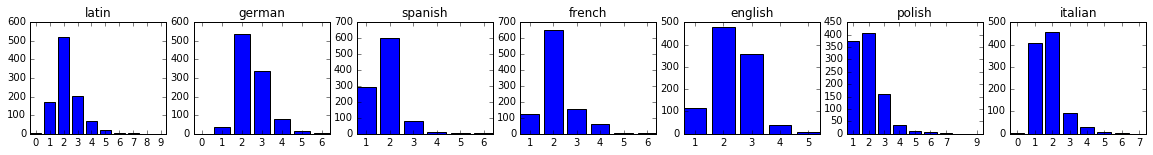

In [35]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(trigram_languages))
fig.set_figheight(2)
fig.set_figwidth(20)

for language, axis in zip(trigram_languages, axes):
    progressive_samples = language.sample_progressive(1000)
    word_lengths, counts = np.unique([len(word) for word in progressive_samples], return_counts=True)
    
    axis.set_xticks(word_lengths)
    axis.set_title(language.info.name)
    axis.bar(word_lengths, counts, align='center')
    
    print u"{}: {}\n".format(language.info.name, u", ".join(progressive_samples[:20]))

plt.show()

Unfortunately, this sampler is spending a lot of time generating short words, and also many repeated words. I suspect that the distribution of word length has an exponential tail. This means that generating long words with rejection sampling will be tragically inefficient.

Sampling words with MCMC
=============
How can we cover our sample space more effectively? This question always seems to have the same answer: [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). Note that the "Markov chain" in "Markov chain Monte Carlo" is a Markov chain where each state is a *sampled word,* and the chain is a series of samples. This is different than the Markov chain used to model word likelihood, which is a Markov chain where each state is a *letter,* and the chain of letters forms a word.

As such, I made a [Metropolis-Hastings sampler](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). I'm initializing each run with an *N*-letter word comprised of randomly uniformly chosen letters. The proposal distribution makes a 50/50 random choice between the following two options: it can replace a single letter of the previous sample with a randomly uniformly chosen letter, or it can swap two letters. Note that both of these moves keep the word at length *N*.

Below, the "sample" words represent samples, taken from the sampler at regular intervals (not sequentially, in order to reduce autocorrelation). They are presented in the order that they were sampled. The "top" words represent the highest-likelihood words that the sampler finds. They are presented with highest likelihood first. I restart the sampler from random initializations many times, in case it tends to get stuck in certain areas of the distribution.

In [36]:
from operator import itemgetter

for language in trigram_languages:
    for word_length in xrange(1, 13):
        samples, top = language.sample_mh(word_length, max_to_store=6, n_runs=100, n_samples=1000*word_length)

        samples_joined = u", ".join(word for word, prob in samples[:6])
        print u"{}-letter {} samples: {}".format(word_length, language.info.name, samples_joined)
        
        top_joined = ", ".join(word for prob, word in reversed(sorted(top, key=itemgetter(0))))
        print u"{}-letter {} top: {}\n".format(word_length, language.info.name, top_joined)
    print

1-letter latin samples: m, d, a, m, d, a
1-letter latin top: a, e, m, s, c, o

2-letter latin samples: et, es, ta, is, is, is
2-letter latin top: es, re, se, et, is, in

3-letter latin samples: ili, sis, lum, con, num, ses
3-letter latin top: que, cum, tum, qui, con, rem

4-letter latin samples: stat, inti, pram, ciam, quis, gute
4-letter latin top: quam, quis, atis, quae, etis, orum

5-letter latin samples: intum, sitem, vitum, intis, serum, perae
5-letter latin top: conis, quium, estis, intis, perum, intum

6-letter latin samples: conium, quisse, iuntem, feriam, silium, ilicat
6-letter latin top: querum, sentis, conium, inatis, sentum, queris

7-letter latin samples: antatis, nonitis, sentant, inturti, liceres, vitione
7-letter latin top: interum, estatis, interis, peratis, sentere, sentiam

8-letter latin samples: inateror, restinis, prantent, antatina, quaectus, ratiatis
8-letter latin top: quitatis, essentis, senterum, essentum, intentis, senteris

9-letter latin samples: ventaess

Encouragingly, the top-likelihood sampled words match the exhaustively-searched words well! Also encouragingly, the "top" words found by the sampler tend to be consistent between runs. These clues indicate that the sampler is probably not completely broken.

These words look pretty good. Once they get long, though, certain three-letter sequences of letters start to repeat (e.g. "dendendenden" in fake-German). This makes a lot of sense, since the model is only aware of the three-letter neighborhood next to each letter.

Using a sampling algorithm to search for high-likelihood points is a slight abuse of the sampler, since that's not what a sampler does. For some reason, it seems to work fine here, probably because the areas it's exploring aren't very large. To get even longer words, it would probably be best to use a real search algorithm.

Detecting foreign-looking words
=================
Time for some more fun! For this tangent, I'll go through the dictionary of each language to find words that seem to belong to other languages. Some of these are obviously loan words, but other ones (e.g. for Latin) just look foreign.

In order to get a ranking, I've simply taken the ratio of the likelihood in the destination languages to the likelihood in the source language.

In [38]:
from operator import itemgetter

from fake_words.fake_words import try_to_store

N_TO_STORE = 5

# Loop over every pair of languages
for language_source in trigram_languages:
    for language_dest in trigram_languages:
        # A heap to store our best results
        best_words = []

        if language_dest is language_source:
            continue
    
        for word in language_source.dictionary:
            word_with_tokens = u" {} ".format(word)
            # Subtraction produces a ratio because these are log probabilities
            ratio = language_dest.get_word_prob(word_with_tokens) - language_source.get_word_prob(word_with_tokens)
            try_to_store(best_words, word, ratio, N_TO_STORE)

        best_words_pretty = ", ".join(word for prob, word in reversed(sorted(best_words, key=itemgetter(0))))
        print u"{} words that look {}: {}".format(language_source.info.name, language_dest.info.name, best_words_pretty)

latin words that look german: andrachnen, andrachlen, dendrachaten, pyrrhichen, jungebar
latin words that look spanish: decharmidabar, decharmidabas, apolactizabar, decharmidandos, decharmidando
latin words that look french: branchai, transfigurans, parochai, chondrillai, ravennai
latin words that look english: asty, branchad, spathad, chelyin, gry
latin words that look polish: chrysoprasie, onycha, sardonycha, zelotypo, chrysopastom
latin words that look italian: leopardale, leopardali, buttutti, chalaziai, leopardi
german words that look latin: --------------------------------------------------------------------------, (http://creativecommons.org/licenses/by-nc/3.0/deed.de)., computersimulation, quantitativ, observatorium
german words that look spanish: violoncello, colorado, parlamentarismus, colonia, casanova
german words that look french: quantitativ, montreux, europaparlament, renaissance, portemonnaie
german words that look english: showdown, journalismus, oppositionspolitiker, 

All right, now I'm having fun!

I always feel slightly offended when I see the words that look English. "Whiskey." "Showdown." "Branchad." "Spathad." "Overbooking!" Is this what English looks like to non-English-speakers? To make myself feel better, I imagine a heavy-set German man with a disproportionately large mustache saying, "braunschweiger," "trochleis," and "weltschmerzes" very seriously.

I also enjoy that the algorithm classifies "jeans" as French. Which is true, just ask any pair of Jeans.

Conclusion
=====
Hopefully this article has illustrated the strengths and limitations of using a Markov model for word structure. It seems to work nicely for short words, but for long words it might need to be augmented by 4-grams or 5-grams, or it might need to be replaced by a tree-structured model.

This is a good start, but this is just the tip of the iceberg in terms of what could be done with a word structure model. Here are a few ideas:
* Easily and automatically generate plausible wrong answers for multiple-choice spelling tests. This could be useful for language learning.
* Train the model on a fake language, and then sample words to create new words in that language.
* There are also many NLP domains that could make use of word structure modeling: optical character recognition, speech recognition, and machine translation come to mind.

Thanks
------
Thanks to my brother [Eric](http://erickernfeld.yolasite.com/) for help with statistics, Spanish, and writing tips!